# Blood cell classifier

The underlying dataset consists of microscopic images (360 x 360 pixels) showing normal white blood cells. The included blood cells are classified as:

1. Neutrophils
2. Eosinophils
3. Basophils
4. Lymphocytes
5. Monocytes
6. Immature Granulocytes (IG)
7. Erythroblasts
8. Platelets/Thrombocytes

In [1]:
# Import libraries
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.applications.resnet50 import preprocess_input, ResNet50
import os
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import seaborn as sns

sns.set_theme(style="ticks")

## 1. Import and preprocess data

The data is first extracted from a zip file and then loaded into a TensorFlow dataset. The image size is reduced to 224 x 224 pixels, the images in the dataset are shuffled and batched to 32, and 20% of the images are kept as test data. The remaining 80% is split again into 80% training data and 20% validation data.

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Import and unzip data
zip_path = os.path.join("/content/drive/MyDrive/Cell images/Data.zip")
with zipfile.ZipFile(zip_path, "r") as zip:
    zip.extractall('/content')

In [2]:
# Import and prepare the first split of datasets
path = os.path.join("/content/Data/")

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
dataset, test_dataset = keras.utils.image_dataset_from_directory(directory=path,
                                                                 image_size=(IMG_WIDTH, IMG_HEIGHT),
                                                                 batch_size=BATCH_SIZE,
                                                                 label_mode="int",
                                                                 validation_split=0.2,
                                                                 subset="both",
                                                                 shuffle=True,
                                                                 seed=42)

# Get class names
class_names = dataset.class_names
print(class_names)

Found 17092 files belonging to 8 classes.
Using 13674 files for training.
Using 3418 files for validation.
['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


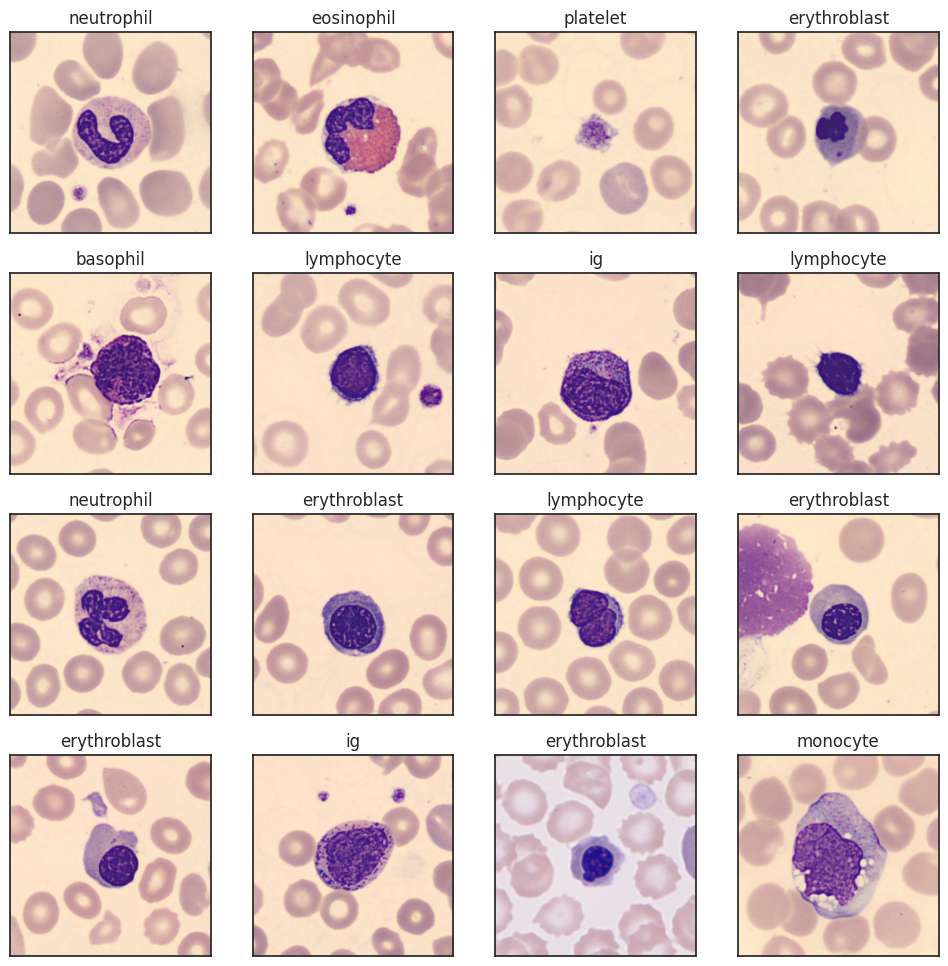

In [19]:
# Plot 16 images from the dataset
fig, ax = plt.subplots(4, 4, figsize=(12,12))
ax = ax.flat
for images, labels in dataset.take(1):
  for i in range(16):
    ax[i].set_title(class_names[labels[i].numpy()])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(images[i].numpy().astype("uint8"))
plt.savefig("Examples.svg", dpi=300)

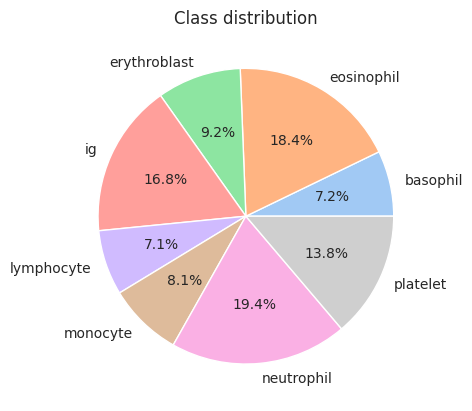

In [20]:
# Check if classes are balanced
labels = np.concatenate([label for image, label in dataset], axis=0)
unique, counts = np.unique(labels, return_counts=True)
plt.pie(x=counts, labels=class_names, autopct='%.1f%%', textprops={'size': 'smaller'},
        colors=sns.color_palette('pastel')[0:8])
plt.title("Class distribution")
plt.savefig("Class distribution.svg", dpi=300)
plt.show()

In [3]:
# Split dataset in train and validation set
num_elements = len(dataset)
train_size = int(0.8 * num_elements)
val_dataset = dataset.skip(train_size).prefetch(tf.data.AUTOTUNE)
train_dataset = dataset.take(train_size).prefetch(tf.data.AUTOTUNE)
# Check length
len(train_dataset), len(val_dataset), len(test_dataset)

(342, 86, 107)

In [4]:
# Check format
for image_batch, labels_batch in train_dataset.take(1):
  print(f"Train data: {image_batch.shape}")
  print(f"Train labels: {labels_batch.shape}")

for image_batch, labels_batch in val_dataset.take(1):
  print(f"Validation data: {image_batch.shape}")
  print(f"Validation labels: {labels_batch.shape}")

for image_batch, labels_batch in test_dataset.take(1):
  print(f"Test data: {image_batch.shape}")
  print(f"Test labels: {labels_batch.shape}")

Train data: (32, 224, 224, 3)
Train labels: (32,)
Validation data: (32, 224, 224, 3)
Validation labels: (32,)
Test data: (32, 224, 224, 3)
Test labels: (32,)


In [5]:
# Check pixel intesities
for image, label in train_dataset.take(1):
  print(tf.reduce_max(image))
  print(tf.reduce_min(image))

tf.Tensor(255.0, shape=(), dtype=float32)
tf.Tensor(3.2101154, shape=(), dtype=float32)


**Conclusion:**

* The 8 classes are unbalanced, with the most common class being neutrophils with 19.4% of all images and the least common class being lymphocytes with 7.1%. Thus, the accuracy of a random model would be 19.4%.
* Pixel intensities range from 3.5 to 255. Therefore, rescaling the pixel intesities is appropriate.

## Model 1 (Baseline DNN)

Consists of a rescaling layer, a flattening layer, a hidden dense layer with 128 neurons and a ReLU activation function, and an output layer with 8 neurons and a softmax activation function.

In [6]:
# Create a lab-book to track the different experiments
lab_book = {}

# Create early stopping callback
early_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True,
                                         monitor="val_accuracy", min_delta=0.005)

In [26]:
# Lab Book Name Entry
name = "Model 1"

# Build model
tf.random.set_seed(42)
model_1 = keras.Sequential([
    layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3)),
    layers.Rescaling(1./255),
    layers.Flatten(),
    layers.Dense(128, activation="relu", kernel_initializer="he_normal"),
    layers.Dense(8, activation="softmax")
])
model_1.summary()

#  Compile the model
model_1.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"]
                )

# Fit the model
history_1 = model_1.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=100,
                        callbacks=[early_cb])

# Write lab-book
lab_book[name] = model_1.evaluate(val_dataset)[1]

# Save model
model_1.save("model1.keras")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 128)               19267712  
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 19268744 (73.50 MB)
Trainable params: 19268744 (73.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
342/342 [==============================] - 42s 111ms/step - loss: 9.1814 - accuracy: 0.1686 - val_loss: 2.0495 - val_accuracy: 0.1879


## Model 2 (Simple CNN)

Consists of a rescaling layer followed by a Conv2D layer with 8 filters, followed by a MaxPool2D layer, a flattening layer and the standard output layer.

In [12]:
# Lab Book Name Entry
name = "Model 2"

# Build model
tf.random.set_seed(42)
model_2 = keras.Sequential(
    [layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
     layers.Rescaling(1./255),
     layers.Conv2D(filters=8, kernel_size=(3,3),
                   padding="same", activation="relu",
                   kernel_initializer="he_normal"),
     layers.MaxPool2D(),
     layers.Flatten(),
     layers.Dense(8, activation="softmax")
     ])

model_2.summary()

# Compile model
model_2.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model
history_2 = model_2.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=100,
                        callbacks=[early_cb])

# Write lab-book
lab_book[name] = model_2.evaluate(val_dataset)[1]

# Save model
model_2.save("model2.keras")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 112, 112, 8)       0         
 g2D)                                                            
                                                                 
 global_average_pooling2d (  (None, 8)                 0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_3 (Dense)             (None, 8)                 72        
                                                                 
Total params: 296 (1.16 KB)
Trainable params: 296 (1.1

KeyboardInterrupt: ignored

**Conclusion:**

* The simple CNN model is highly overfitting. Therefore, data augmentation is implemented.

## Model 3 (CNN with data augmentation)

Same model architecture as Model 2, but this time with a built-in data augmentation layer.


In [7]:
# Set up data augmentation layers
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.4)
    ])

In [29]:
# Lab Book Name Entry
name = "Model 3"

# Build model
tf.random.set_seed(42)
model_3 = keras.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Rescaling(1./255),
    data_augmentation,
    layers.Conv2D(filters=8, kernel_size=(3,3),
                  padding="same", activation="relu",
                  kernel_initializer="he_normal"),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(8, activation="softmax")
    ])

model_3.summary()

# Compile model
model_3.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model
history_3 = model_3.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=100,
                        callbacks=[early_cb])

# Write lab-book
lab_book[name] = model_3.evaluate(val_dataset)[1]

# Save model
model_3.save("model3.keras")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 112, 112, 8)       0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_3 (Dense)             (None, 8)                 802824    
                                                      

**Conclusion:**

* Data augmentation effectively prevented overfitting, allowing a more complex CNN architecture to be built.

## Model 4 (More complex CNN with data augmentation)

First, the images are rescaled and augmented. Then there are 3 Conv blocks between the preprocessing layers and the output layer. Each Conv block consists of a Conv2D layer followed by a MaxPool2D layer. The filter size increases from 32 to 64 to 128 filters, the activation function is ReLU, and the kernel size is (3,3) except for the first Conv block (5,5).

In [8]:
# Lab Book Name Entry
name = "Model 4"

# Build model
tf.random.set_seed(42)
model_4 = keras.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Rescaling(1./255),
    data_augmentation,
    layers.Conv2D(filters=8, kernel_size=(5,5),
                  padding="same", activation="relu",
                  kernel_initializer="he_normal"),
    layers.MaxPool2D(),
    layers.Conv2D(filters=16, kernel_size=(3,3),
                  padding="same", activation="relu",
                  kernel_initializer="he_normal"),
    layers.MaxPool2D(),
    layers.Conv2D(filters=32, kernel_size=(3,3),
                  padding="same", activation="relu",
                  kernel_initializer="he_normal"),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(8, activation="softmax")
    ])

model_4.summary()

# Compile model
model_4.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model
history_4 = model_4.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=100,
                        callbacks=[early_cb])

# Write lab-book
lab_book[name] = model_4.evaluate(val_dataset)[1]

# Save model
model_4.save("model4.keras")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 8)       608       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 16)        0         
 g2D)                                                 

**Conclusion:**

* Accuracy increased by about 10% with the more complex CNN model without significant overfitting.

## Model 5 (Wide and deep CNN)

Similar to model 4, there are 3 Conv blocks after the data augmentation. However, in this model there is a separate Conv block that scans a large area (20 x 20 pixels) and feeds this output directly to the top layers. This should capture more low-level features in the images and contribute to performance.

In [9]:
# Lab Book Name Entry
name = "Model 5"

# Build model
tf.random.set_seed(42)

inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
rescaling = layers.Rescaling(1./255)(inputs)
augmentation = data_augmentation(rescaling)
deep_path = layers.Conv2D(filters=8, kernel_size=(5,5), padding="same",
                          activation="relu", kernel_initializer="he_normal")(augmentation)
wide_path = layers.Conv2D(filters=8, kernel_size=(20,20), padding="same",
                          activation="relu", kernel_initializer="he_normal")(augmentation)
x = layers.MaxPool2D()(deep_path)
x = layers.Conv2D(filters=16, kernel_size=(3,3), padding="same",
                  activation="relu", kernel_initializer="he_normal")(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), padding="same",
                  activation="relu", kernel_initializer="he_normal")(x)
x = layers.MaxPool2D()(x)
flatten1 = layers.Flatten()(x)
flatten2 = layers.Flatten()(wide_path)
concat = layers.Concatenate()([flatten1, flatten2])
outputs = layers.Dense(8, activation="softmax")(concat)
model_5 = keras.Model(inputs=inputs, outputs=outputs)

model_5.summary()

# Compile model
model_5.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model
history_5 = model_5.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=100,
                        callbacks=[early_cb])

# Write lab-book
lab_book[name] = model_5.evaluate(val_dataset)[1]

# Save model
model_5.save("model5.keras")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 sequential (Sequential)     (None, 224, 224, 3)          0         ['rescaling_1[0][0]']         
                                                                                                  
 conv2d_3 (Conv2D)           (None, 224, 224, 8)          608       ['sequential[1][0]']          
                                                                                              

In [10]:
# Check the performances of all models so far
lab_book

{'Model 4': 0.9274725317955017, 'Model 5': 0.9355311393737793}

**Conclusion:**

The wide and deep architecture of Model 5 was beneficial to its performance, but the computational cost is tremendous.

Therefore, a different approach is chosen. The ResNet architecture is similar to the Model 5 architecture in that it also skips deep paths to propagate low-level features.

## Model 6 (Feature extraction with ResNet50)


In [14]:
# Prepare data for ResNet50 input
train_dataset_resnet = train_dataset.map(lambda X, y: (preprocess_input(X), y)).prefetch(tf.data.AUTOTUNE)
val_dataset_resnet = val_dataset.map(lambda X, y: (preprocess_input(X), y)).prefetch(tf.data.AUTOTUNE)
test_dataset_resnet = test_dataset.map(lambda X, y: (preprocess_input(X), y)).prefetch(tf.data.AUTOTUNE)

# Check format
for image_batch, labels_batch in train_dataset_resnet.take(1):
  print(f"Train data: {image_batch.shape}")
  print(f"Train labels: {labels_batch.shape}")

for image_batch, labels_batch in val_dataset_resnet.take(1):
  print(f"Validation data: {image_batch.shape}")
  print(f"Validation labels: {labels_batch.shape}")

for image_batch, labels_batch in test_dataset_resnet.take(1):
  print(f"Test data: {image_batch.shape}")
  print(f"Test labels: {labels_batch.shape}")

Train data: (32, 224, 224, 3)
Train labels: (32,)
Validation data: (32, 224, 224, 3)
Validation labels: (32,)
Test data: (32, 224, 224, 3)
Test labels: (32,)


In [15]:
# Check pixel intesities
for image, label in train_dataset_resnet.take(1):
  print(tf.reduce_max(image))
  print(tf.reduce_min(image))

tf.Tensor(135.2933, shape=(), dtype=float32)
tf.Tensor(-115.27378, shape=(), dtype=float32)


In [1]:
# Name the model
name = "Model 6"

# Download the pretrained resnet model and save it as a layer
feature_extraction_layer = ResNet50(include_top=False,
                                    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze all layers of base model
feature_extraction_layer.trainable = False

# Build model
tf.random.set_seed(42)
model_6 = keras.Sequential([feature_extraction_layer,
                            layers.GlobalMaxPool2D(),
                            layers.Dense(8, activation="softmax")
                            ])

model_6.summary()

# Compile model
model_6.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model
history_6 = model_6.fit(train_dataset_resnet,
                        validation_data=val_dataset_resnet,
                        epochs=100,
                        callbacks=[early_cb])

# Write lab-book
lab_book[name] = model_6.evaluate(val_dataset_resnet)[1]

# Save model
model_6.save("model6.keras")

NameError: ignored

## Model 7 (Transfer learning with ResNet50)

Same architecture as before, but this time the ResNet50 base model is completely unfrozen and the entire model is trained.

In [36]:
# Name the model
name = "Model 7"

# Unfreeze all layers of base model
feature_extraction_layer.trainable = True

# Build model
tf.random.set_seed(42)
model_7 = keras.Sequential([data_augmentation,
                             feature_extraction_layer,
                             layers.GlobalAveragePooling2D(),
                             layers.Dense(8, activation="softmax")
                            ])


# Compile model
model_7.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.Adam(learning_rate = 0.0001),
                metrics=["accuracy"])

# Fit model
history_7 = model_7.fit(train_dataset_resnet,
                        validation_data=val_dataset_resnet,
                        epochs=100,
                        callbacks=[early_cb])

# Write lab-book
lab_book[name] = model_7.evaluate(val_dataset_resnet)[1]

# Save model
model_7.save("model7.keras")

Epoch 1/100
342/342 [==============================] - 179s 426ms/step - loss: 0.1791 - accuracy: 0.9415 - val_loss: 0.1428 - val_accuracy: 0.9586
Epoch 2/100
342/342 [==============================] - 143s 417ms/step - loss: 0.0796 - accuracy: 0.9737 - val_loss: 0.1368 - val_accuracy: 0.9637
Epoch 3/100
342/342 [==============================] - 162s 472ms/step - loss: 0.0623 - accuracy: 0.9783 - val_loss: 0.0595 - val_accuracy: 0.9839
Epoch 4/100
342/342 [==============================] - 162s 472ms/step - loss: 0.0467 - accuracy: 0.9846 - val_loss: 0.1717 - val_accuracy: 0.9451
Epoch 5/100
342/342 [==============================] - 162s 472ms/step - loss: 0.0438 - accuracy: 0.9846 - val_loss: 0.0996 - val_accuracy: 0.9758
Epoch 6/100
86/86 [==============================] - 25s 139ms/step - loss: 0.0612 - accuracy: 0.9832


## Investigate the errors

Confusion matrix of best model
Is feature engineering possible?

In [41]:
y_pred = []
y_pred_proba = []  # store predicted labels
y_true = []  # store true labels


# iterate over the dataset
for image_batch, label_batch in train_dataset_resnet:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_7.predict(image_batch, verbose=0)
   # append predicted labels
   y_pred_proba.append(preds)
   y_pred.append(np.argmax(preds, axis=-1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = tf.cast(correct_labels, "int64")
predicted_labels = tf.concat([item for item in y_pred], axis = 0)
predicted_proba = tf.concat([item for item in y_pred_proba], axis = 0)

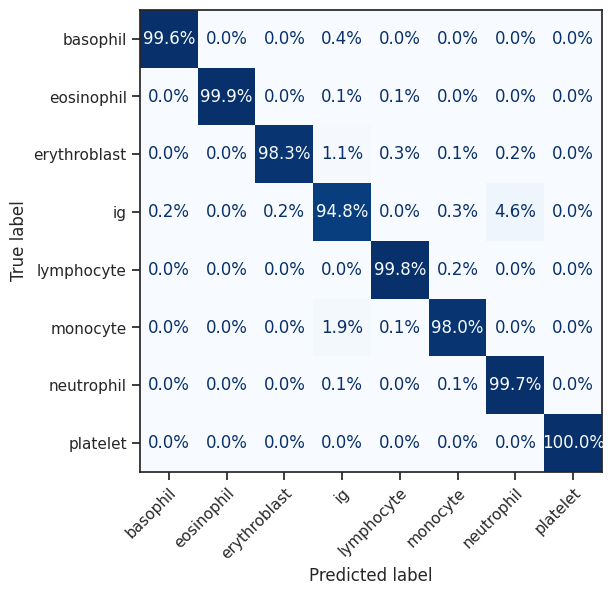

In [42]:
# Check confusion matrix of best model
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(figsize=(10,6))
ConfusionMatrixDisplay.from_predictions(y_true=correct_labels,
                                        y_pred=predicted_labels,
                                        display_labels=class_names,
                                        normalize="true",
                                        cmap="Blues",
                                        values_format=".1%",
                                        colorbar=False,
                                        ax=axes)
axes.set_xticklabels(labels=class_names, rotation=45, ha='right', rotation_mode='anchor')
plt.show()

Take a look at the most frequent mistakes.

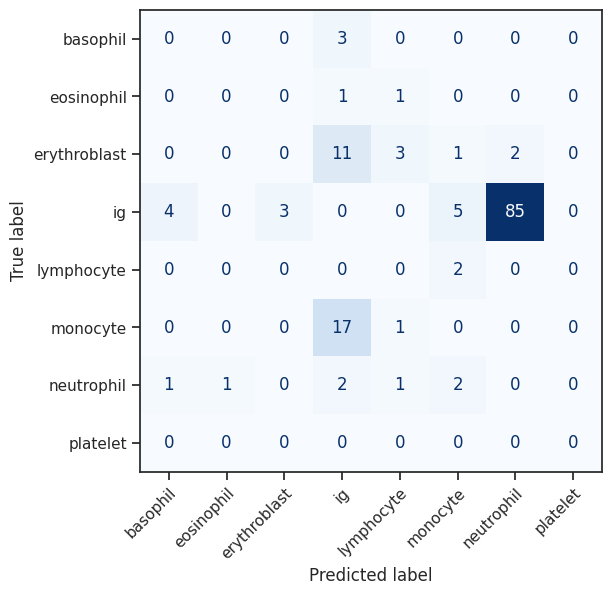

In [43]:
# Plot confusion matrix with zero weigth in the correct predictions
sample_weight = (correct_labels != predicted_labels)
fig, axes = plt.subplots(figsize=(10,6))
ConfusionMatrixDisplay.from_predictions(y_true=correct_labels,
                                        y_pred=predicted_labels,
                                        display_labels=class_names,
                                        cmap="Blues",
                                        sample_weight=sample_weight,
                                        ax=axes,
                                        colorbar=False)
axes.set_xticklabels(labels=class_names, rotation=45, ha='right', rotation_mode='anchor')
plt.show()

The biggest erros come from:
* Mistaken ig for beeing neutrophil
* Mistaken monocyte for beeing ig
* Mistaken erythroblast for beeing ig

In [44]:
from sklearn import metrics
print(
    "Classification report rebuilt from confusion matrix:\n"
    f"{metrics.classification_report(y_true=correct_labels, y_pred=predicted_labels)}\n"
)

Classification report rebuilt from confusion matrix:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       794
           1       1.00      1.00      1.00      1993
           2       1.00      0.98      0.99      1019
           3       0.98      0.95      0.96      1862
           4       0.99      1.00      1.00       806
           5       0.99      0.98      0.98       887
           6       0.96      1.00      0.98      2080
           7       1.00      1.00      1.00      1503

    accuracy                           0.99     10944
   macro avg       0.99      0.99      0.99     10944
weighted avg       0.99      0.99      0.99     10944


